- Before move on, please run `install.sh` first.

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import gc
import time
import numpy as np
import pandas as pd
import tensorflow as tf
# tf.debugging.set_log_device_placement(True)

%matplotlib inline
from keras.preprocessing.image import array_to_img
import copy
import seaborn as sns
import cv2 as cv
import pickle
import tensorflow_probability as tfp
from tensorflow.keras.layers import AveragePooling2D
import shutil
import sys 

sys.path.append("../models/GPA")
sys.path.append("../")
from gpa import GPA
from utils import *
from simu_auxiliary import *


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


2024-05-04 03:37:00.570785: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 03:37:01.154578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:b3:00.0, compute capability: 6.0


In [3]:
def MSE(x, y):
    mse = tf.reduce_mean((x - y)**2)
    return mse

def MSE_median(x, y):
    mse = np.median((x - y)**2)
    return mse

In [4]:
T = 100                    # number of replications
N_list = [100, 500, 1000]  # number of images
p = 540
q = 960
G = 500

print(f"total replications T: {T}")
print(f"total sample size_list N_list:{N_list}")
print(f"image size p*q: {p}*{q}")
print(f"number of ticks on x axis G: {G}")

total replications T: 100
total sample size_list N_list:[100, 500, 1000]
image size p*q: 540*960
number of ticks on x axis G: 500


2024-05-04 03:37:01.502803: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


TensorShape([1, 540, 960])

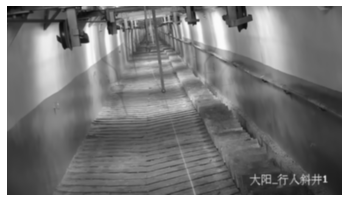

In [5]:
avg_pool_2d_mean = AveragePooling2D(pool_size=(5, 5), strides=1, padding="same")
# the mean image
mean = np.load('./mean-540.npy')
mean = mean.reshape([1, p, q, 1])
mean = avg_pool_2d_mean(mean)
mean = tf.reshape(mean, (1, p, q))

show_img_one_channel(mean[0])
mean.shape

In [6]:
sigma = 0.2
test_size = 100

In [7]:
tick_list = np.random.uniform(size=G)
tick_tensor = tf.concat([tf.ones([1, p, q]) * tick for tick in tick_list], axis=0)

In [8]:
# true density
f_true = compute_true_density(tick_list, mean, sigma)

# location_weight
truncate_width = 3

tfd = tfp.distributions
dist = tfd.TruncatedNormal(loc=mean, scale=sigma, low=[0.], high=[1.])

True density shape: (500, 540, 960)


In [9]:
M = p * q

In [10]:
N = 1000
alpha = np.log(p*q) / np.log(N)
bandwidth, bandwidth_star = compute_optimal_bandwidths(N, M, sigma)
print(f"1/q / bandwidth:{1/q / bandwidth:.6f}")

N, bandwidth, bandwidth_star

Optimal bandwidth from Rule of Thumb: 0.015302491923891564
Optimal bandwidth* from GPA estimation: 0.0011708312954038327
1/q / bandwidth:0.068072


(1000, 0.015302491923891564, 0.0011708312954038327)

In [11]:
# N = 1000
# alpha = np.log(p*q) / np.log(N)
# bandwidth, bandwidth_star = compute_optimal_bandwidths(N, M, sigma)
# print(f"1/q / bandwidth:{1/q / bandwidth:.6f}")

# N, bandwidth, bandwidth_star

In [12]:
experiment_stats = {"N": [],
                    "t": [],
                    "CD_mse": [],
                    "DS_mse": [],
                    "GPA_CD_mse": [],
                    "GPA_DS_mse": [],
                    "DS_mse": [],
                    "CD_time": [],
                    "DS_time": [],
                    "GPA_CD_time": [],
                    "GPA_DS_time": []}

In [14]:
N_list = [1000]

In [ ]:
for N in N_list:
    print(f"============= N:{N} =============")
    alpha = np.log(p * q) / np.log(N)  # alpha
    path = f'../../../simulate_img_N={N}_GPU3'  # path to save N simulate image

    # optimal bandwidth
    bandwidth, bandwidth_star = compute_optimal_bandwidths(N, M, sigma)
    location_weight_tensor = compute_location_weight(p, q, bandwidth, truncate_width)
    location_weight_tensor = tf.reshape(location_weight_tensor, [truncate_width, truncate_width, 1, 1])
    location_weight_tensor = tf.cast(location_weight_tensor, tf.float32)

    for t in range(T): # repliacte
        print(f"============= The {t}th replication with N samlpes:{N} =============")
        seed = N + t
        tf.random.set_seed(seed) # set random seed in one replication of N
        np.random.seed(seed)
        CD_mse = 0
        DS_mse = 0
        GPA_CD_mse = 0
        GPA_DS_mse = 0
        CD_time = 0
        DS_time = 0
        GPA_CD_time = 0
        GPA_DS_time = 0
        
        # generate N generated N simulation images
        generate_simulate_data(path, N, mean, sigma)
        
        # pre-computed CD and DS matrix
        CD_matrix = compute_CD_matrix(path, N, G, p, q, bandwidth, tick_tensor)
        DS_matrix = compute_DS_matrix(CD_matrix, location_weight_tensor)
        CD_matrix = tf.squeeze(CD_matrix)
        DS_matrix = tf.squeeze(DS_matrix)
        
        # density comparison
        for test_i in range(test_size): # 生成测试图片
            print(f"[TEST] image No.{test_i}")
            test_img = tf.ones([p, q]) * np.random.uniform()
            oracle_test = tf.squeeze(dist.prob(test_img))
            
            # CD estimation
            print(f"[TEST] compute CD estimator")
            t1 = time.time()
            CD_test = test_CD(p, q, test_img, bandwidth, path)
            CD_test = tf.reshape(CD_test, (1, p, q))
            t2 = time.time()
            CD_time += (t2 - t1) / test_size
            
            # DS estimation
            print(f"[TEST] compute DS estimator")
            t3 = time.time()
            DS_test = compute_DS_matrix(CD_test, location_weight_tensor)
            t4 = time.time()
            DS_time += (t4 - t3 + t2 - t1) / test_size
            
            # GPA-CD estimation
            print(f"[TEST] compute GPA-CD estimator")
            t1 = time.time()
            Omega2_star = K_tf(tick_tensor - test_img, bandwidth_star)
            Omega1_star = Omega2_star * CD_matrix
            Omega1_star = tf.reduce_sum(Omega1_star, axis=0)
            Omega2_star = tf.reduce_sum(Omega2_star, axis=0)
            GPA_CD_test = Omega1_star / Omega2_star
            t2 = time.time()
            GPA_CD_time += (t2 - t1) / test_size
            
            # GPA-DS estimation
            print(f"[TEST] compute GPA-DS estimator")
            t1 = time.time()
            Omega2_star = K_tf(tick_tensor - test_img, bandwidth_star)
            Omega1_star = Omega2_star * DS_matrix
            Omega1_star = tf.reduce_sum(Omega1_star, axis=0)
            Omega2_star = tf.reduce_sum(Omega2_star, axis=0)
            GPA_DS_test = Omega1_star / Omega2_star
            t2 = time.time()
            GPA_DS_time += (t2 - t1) / test_size

            ###################### Compute MSE ####################
            # 1. MSE of the CD estimator
            CD_test = tf.squeeze(CD_test)
            CD_mse += MSE(oracle_test, CD_test) / test_size
            # 2. MSE of the DS estimator
            DS_test = tf.squeeze(DS_test)
            DS_mse += MSE(oracle_test, DS_test) / test_size
            # 3. MSE of the GPA-CD estimator
            GPA_CD_test = tf.squeeze(GPA_CD_test)
            GPA_CD_mse += MSE(oracle_test, GPA_CD_test) / test_size
            # 4. MSE of the GPA-DS estimator
            GPA_DS_test = tf.squeeze(GPA_DS_test)
            GPA_DS_mse += MSE(oracle_test, GPA_DS_test) / test_size
            print(f"Sample size N:{N}")
            print(f"CD MSE: {CD_mse.numpy():.8f}")
            print(f"DS MSE: {DS_mse.numpy():.8f}")
            print(f"GPA_CD MSE: {GPA_CD_mse.numpy():.8f}")
            print(f"GPA_DS MSE: {GPA_DS_mse.numpy():.8f}")
        
        experiment_stats["N"].append(N)
        experiment_stats["t"].append(t)
        experiment_stats["CD_mse"].append(CD_mse.numpy())
        experiment_stats["DS_mse"].append(DS_mse.numpy())
        experiment_stats["GPA_CD_mse"].append(GPA_CD_mse.numpy())
        experiment_stats["GPA_DS_mse"].append(GPA_DS_mse.numpy())
        experiment_stats["CD_time"].append(CD_time)
        experiment_stats["DS_time"].append(DS_time)
        experiment_stats["GPA_CD_time"].append(GPA_CD_time)
        experiment_stats["GPA_DS_time"].append(GPA_DS_time)
        experiment_stats_csv = pd.DataFrame(experiment_stats)
        experiment_stats_csv.to_csv(f'./simulation(N={N}).csv')

============= N:1000 =============
Optimal bandwidth from Rule of Thumb: 0.015302491923891564
Optimal bandwidth* from GPA estimation: 0.0011708312954038327
============= The 0th replication with N samlpes:1000 =============
-[CD] Successfully compute classical density with N=1000 at ../../../simulate_img_N=1000_GPU3
[TEST] image No.0
[TEST] compute CD estimator
[TEST] compute DS estimator
[TEST] compute GPA-CD estimator
[TEST] compute GPA-DS estimator
Sample size N:1000
CD MSE: 0.00018076
DS MSE: 0.00003661
GPA_CD MSE: 0.00018034
GPA_DS MSE: 0.00003657
[TEST] image No.1
[TEST] compute CD estimator
[TEST] compute DS estimator
[TEST] compute GPA-CD estimator
[TEST] compute GPA-DS estimator
Sample size N:1000
CD MSE: 0.00031931
DS MSE: 0.00008049
GPA_CD MSE: 0.00031865
GPA_DS MSE: 0.00008043
[TEST] image No.2
[TEST] compute CD estimator
[TEST] compute DS estimator
[TEST] compute GPA-CD estimator
[TEST] compute GPA-DS estimator
Sample size N:1000
CD MSE: 0.00036835
DS MSE: 0.00009606
GPA_C

In [43]:
DS_mse

0.002795512

In [104]:
def plot_density(s, tick_list, f_true, classic_density_tensor, DS_tensor):
    density_true = f_true[:, s[0], s[1]]
    density_hat = classic_density_tensor[:, s[0], s[1]]
    density_doubly_all = DS_tensor[:, s[0], s[1]]
    plt.scatter(tick_list, density_true, marker='o', s=2, label=f"True at ({s[0]}, {s[1]})")
    plt.scatter(tick_list, density_hat, marker='^', s=1, label=f"Classical")
    plt.scatter(tick_list, density_doubly_all, marker='+', s=1, label=f"Doubly")
    
    plt.legend(loc=3)
    plt.show()

Sample size N: 1000


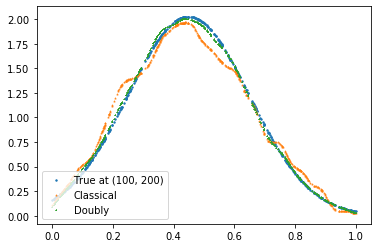

In [105]:
print("Sample size N:", N)
s = (100, 200)
plot_density(s, tick_list, f_true, classic_density_tensor, DS_tensor)

In [110]:
tick_list.shape

(500,)

In [111]:
density_true = f_true[:, s[0], s[1]]
density_classic = classic_density_tensor[:, s[0], s[1]]
density_doubly = DS_tensor[:, s[0], s[1]]

density_stats = {"tick": tick_list,
                "density_true": density_true,
                 "density_classic": density_classic,
                 "density_doubly": density_doubly}
density_stats_csv = pd.DataFrame(density_stats)
density_stats_csv.to_csv(f'./density_stats_N={N}.csv')

In [65]:
mse_classic = MSE(tf.squeeze(test_true_density), test_classic_density_tensor)
mse_doubly = MSE(tf.squeeze(test_true_density), test_DS_tensor)
mse_GPA = MSE(tf.squeeze(test_true_density), GPA_density)

mse_classic_median = MSE_median(tf.squeeze(test_true_density), test_classic_density_tensor)
mse_doubly_median = MSE_median(tf.squeeze(test_true_density), test_DS_tensor)
mse_GPA_median = MSE_median(tf.squeeze(test_true_density), GPA_density)


print(f"Sample size N:{N}")
print(f"h:{bandwidth} and h*:", {round(bandwidth_star, 4)})
print(f"classic density MSE:", {round(mse_classic.numpy(), 4)}, f"\tclassic density MSE_mean:", {round(mse_classic_median, 6)}, f'\tTime:{round(classic_time, 4)}')
print(f"doubly density MSE:", {round(mse_doubly.numpy(), 4)}, f"\tdoubly density MSE_mean:", {round(mse_doubly_median, 6)}, f'\tTime:{round(doubly_time, 4)}')
print(f"GPA density MSE:", {round(mse_GPA.numpy(), 4)}, f"\tGPA density MSE_mean:", {round(mse_GPA_median, 6)}, f'\tTime:{round(GPA_time, 4)}')


Sample size N:1000
h:0.02315827506916077 and h*: {0.0034}
classic density MSE: {0.0042} 	classic density MSE_mean: {0.000216} 	Time:19.811
doubly density MSE: {0.0467} 	doubly density MSE_mean: {4.2e-05} 	Time:19.8383
GPA density MSE: {0.0468} 	GPA density MSE_mean: {4.1e-05} 	Time:0.0185
